In [1]:
#import os
#os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
#os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
suptitles = {a+topo : a+", "+{'_2pi':r"$\pi\pi$", '_pi_p':r"$\pi p$"}[topo] for a in 'D C Fe Pb'.split() for topo in '_2pi _pi_p'.split()}

In [3]:
from __future__ import absolute_import, division, print_function
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], True)
tf.config.experimental.set_memory_growth(physical_devices[1], True)

In [4]:
import time
import numpy as np
import pandas as pd
#import root_pandas as rpd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
from matplotlib.colors import LogNorm
#from root_pandas import read_root
from matplotlib import rc
from numpy import inf


import sys,pandas as pd, matplotlib , matplotlib.pyplot as plt, matplotlib.lines , numpy as np, math, pylab
#import ROOT
#from ROOT import TFile

#import root_pandas
%matplotlib inline

import uproot

rc('text', usetex=True)

import matplotlib as mpl
#rc('font', family='serif')
#rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

#
mpl.rcParams.update({'font.size': 19})
#mpl.rcParams.update({'legend.fontsize': 18})
mpl.rcParams.update({'xtick.labelsize': 18}) 
mpl.rcParams.update({'ytick.labelsize': 18}) 
mpl.rcParams.update({'text.usetex' : False})
mpl.rcParams.update({'axes.labelsize': 18}) 
mpl.rcParams.update({'legend.frameon': False}) 
plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

In [5]:
# Global plot settings
from matplotlib import rc
import matplotlib.font_manager

#rc('font', family='serif')
#rc('text', usetex=True)
rc('font', size=22)
rc('xtick', labelsize=15)
rc('ytick', labelsize=15)
rc('legend', fontsize=15)

In [6]:
# Define default plot styles
plot_style_0 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'linestyle': '--',
    'density': True
}

plot_style_1 = {
    'histtype': 'step',
    'color': 'black',
    'linewidth': 2,
    'density': True
}

plot_style_2 = {'alpha': 0.5, 'density': True}

In [7]:
# Check Versions
print(tf.__version__)  # 1.15.0
print(tensorflow.keras.__version__)  # 2.2.4

2.5.0
2.5.0


## Obtain datasets and simulations

In [8]:
import imp,root_pandas
imp.reload(root_pandas)
dfs_all = {a : root_pandas.read_root("Pairs_%s.root" %a.replace("D_",""),a) for a in "D_C C D_Fe Fe Pb D_Pb".split()}
dfs_all.update({a+"_trigger" : root_pandas.read_root("Pairs_%s.root" %a.replace("D_",""),a+"_trigger") for a in "D_C C D_Fe Fe Pb D_Pb".split()})
#now load MC
#dfs_all.update({'MC_'+a : root_pandas.read_root("/home/seba/CreatePairTuples/MC_Pairs_%s.root" %a,a) for a in "Pb D C Fe".split()})
dfs_all.update({'MC_'+a : root_pandas.read_root("MC_Pairs_%s.root" %a,a) for a in "D C Fe Pb".split()})
dfs_all.update({'MC_' + a+"_trigger" : root_pandas.read_root("MC_Pairs_%s.root" %a,a+"_trigger") for a in "D C Fe Pb".split()})


dfs_all['D'] = pd.concat([dfs_all['D_'+a] for a in 'C Fe Pb'.split()])
dfs_all['D_trigger'] = pd.concat([dfs_all['D_'+a+'_trigger'] for a in 'C Fe Pb'.split()])

#for a in 'D_C D_Fe D_Pb'.split():
#    if a in dfs_all.keys():
#        del dfs_all[a]
#    if a+"_trigger" in dfs_all.keys():
#        del dfs_all[a+"_trigger"]

/home/sebouh/.local/lib/python3.8/site-packages/uproot3/__init__.py:127: FutureWarning: Consider switching from 'uproot3' to 'uproot', since the new interface became the default in 2020.

    pip install -U uproot

In Python:

    >>> import uproot
    >>> with uproot.open(...) as file:
    ...

  warnings.warn(
/home/sebouh/.local/lib/python3.8/site-packages/awkward0/__init__.py:12: FutureWarning: Consider switching from 'awkward0' to 'awkward', since the new interface became the default in 2020.

    pip install -U awkward

In Python:

    >>> import awkward as ak
    >>> new_style_array = ak.from_awkward0(old_style_array)
    >>> old_style_array = ak.to_awkward0(new_style_array)

  warnings.warn(


In [9]:
import R2h_module



for key in list(dfs_all.keys()):
    if '_2pi' in key or '_pi_p' in key or '_trigger' in key:
        continue
    df = dfs_all[key]
    print(df.columns)
    df.eval('inelasticity = nu/5.014', inplace=True)
    df.eval('diff_phi_cm = h1_cm_ph-h2_cm_ph', inplace=True)
    df.eval('pi='+str(np.pi),inplace=True) #not sure why eval doesn't know what pi is.  
    df.eval('diff_phi_cm = 2*pi*(diff_phi_cm<-pi)-2*pi*(diff_phi_cm>pi)')
    df.eval('h1_e = h1_z*nu', inplace=True)
    df.eval('h2_e = h2_z*nu', inplace=True)
    df.eval('h2_mass = 0.13957*(abs(h2_pid)==211)+.93827208816*(abs(h2_pid)==2212)', inplace=True)
    df.eval('h1_p = sqrt(h1_e*h1_e-0.13957*0.13957)', inplace=True)
    df.eval('h2_p = sqrt(h2_e*h2_e-h2_mass*h2_mass)', inplace=True)
    df.eval('diff_rap_cm = drap',inplace=True)
    print(df.columns)
    if "MC" not in key:
        dfs_all[key+"_2pi"] = R2h_module.applyCuts(R2h_module.applyCutsPair(df,h2Proton=False)).query("h1_pid*h2_pid<0")
        dfs_all[key+"_pi_p"] = R2h_module.applyCuts(R2h_module.applyCutsPair(df,h2Proton=True))
    else :
        dfs_all[key+"_2pi"] = R2h_module.applyCuts(df).query("h1_pid*h2_truth_pid==-211**2").query("h2_truth_z>0.05")
        dfs_all[key+"_pi_p"] = R2h_module.applyCuts(df).query("h1_pid*h2_truth_pid==-2212*211")
    

Index(['dphi', 'dphi_lab', 'drap', 'h1_z', 'h2_z', 'h1_cm_pt', 'h2_cm_pt',
       'h1_xf', 'h2_xf', 'h1_rap', 'ycm', 'h2_rap', 'h1_pid', 'h2_pid',
       'h1_cm_ph', 'h2_cm_ph', 'h1_cm_th', 'h2_cm_th', 'pair_mass', 'pair_pt',
       'mx_eh1h2x', 'mx_eh1x', 'mx_eh2x', 't', 'Q2', 'nu', 'W', 'SampFracEl25',
       'SampFracEl20', 'TargTypeSM', 'TargType', 'x', 'u', 'h1_ph', 'h1_th',
       'h2_ph', 'h2_th', 'h1_deltaZ', 'h2_deltaZ', 'h1_Nphe', 'h2_Nphe',
       'h1_Sector', 'h2_Sector', 'h1_FidCut', 'h2_FidCut', 'h1_FidCutPiPlus',
       'h2_FidCutPiPlus', 'h1_Chi2CC', 'h2_Chi2CC', 'h1_StatCC', 'h2_StatCC',
       'h1_Betta', 'h2_Betta', 'h1_T4', 'h2_T4', 'evnt'],
      dtype='object')
Index(['dphi', 'dphi_lab', 'drap', 'h1_z', 'h2_z', 'h1_cm_pt', 'h2_cm_pt',
       'h1_xf', 'h2_xf', 'h1_rap', 'ycm', 'h2_rap', 'h1_pid', 'h2_pid',
       'h1_cm_ph', 'h2_cm_ph', 'h1_cm_th', 'h2_cm_th', 'pair_mass', 'pair_pt',
       'mx_eh1h2x', 'mx_eh1x', 'mx_eh2x', 't', 'Q2', 'nu', 'W', 'SampFracEl25',
  

1.0< Q2 <4.0 2114873  (100.00  %)
2.2 < nu < 4.2 2085841  (98.63  %)
secondary hadrons are pions 1711797  (82.07  %)
(h1_z+h2_z)<1.0 1500854  (87.68  %)
(h1_pid*h2_pid)<0, opposite charge pions 724656  (48.28  %)
kinematic limits for h2_z 713044  (98.40  %)
kinematic limits for dphi 712408  (99.91  %)
kinematic limits for pair_mass 668366  (93.82  %)
leading hadrons are pions 209506  (31.35  %)
0.2<h2_p<5.0 209506  (100.00  %)
0.2<h1_p<5.0 209506  (100.00  %)
px in gamma* frame is <0.4 GeV 197891  (94.46  %)
px in gamma* frame is <0.4 GeV 197891  (100.00  %)
10<h2_th<90 197751  (99.93  %)
Theta/P fiducial region selected for secondary hadron 197751  (100.00  %)
10< h1_th<90 197751  (100.00  %)
Theta/P fiducial region selected for trigger hadron 197751  (100.00  %)
Entries before cut  197751
Q2>1.0 and Q2<4.0 197751  (100.00  %)
0.2<h1_p<5.0  197751  (100.00  %)
inelasticity < 0.85 197751  (100.00  %)
h1_pid = pions (trigger) 197751  (100.00  %)
2.2 < nu <4.2 197751  (100.00  %)
px in g

1.0< Q2 <4.0 1220015  (100.00  %)
2.2 < nu < 4.2 1205719  (98.83  %)
secondary hadrons are protons 661741  (54.88  %)
leading hadrons are pions 72155  (10.90  %)
0.2<h2_p<5.0 72138  (99.98  %)
0.2<h1_p<5.0 72134  (99.99  %)
px in gamma* frame is <0.4 GeV 65370  (90.62  %)
px in gamma* frame is <0.4 GeV 65370  (100.00  %)
10<h2_th<90 64531  (98.72  %)
Theta/P fiducial region selected for secondary hadron 64531  (100.00  %)
10< h1_th<90 64515  (99.98  %)
Theta/P fiducial region selected for trigger hadron 64515  (100.00  %)
Entries before cut  64515
Q2>1.0 and Q2<4.0 64515  (100.00  %)
0.2<h1_p<5.0  64515  (100.00  %)
inelasticity < 0.85 64515  (100.00  %)
h1_pid = pions (trigger) 64515  (100.00  %)
2.2 < nu <4.2 64515  (100.00  %)
px in gamma* frame is <0.4 GeV 64515  (100.00  %)
10< h1_th<90 64515  (100.00  %)
Theta/P fiducial region selected for trigger 64515  (100.00  %)
Index(['dphi', 'dphi_lab', 'drap', 'h1_z', 'h2_z', 'h1_cm_pt', 'h2_cm_pt',
       'h1_xf', 'h2_xf', 'h1_rap', 'ycm

Q2>1.0 and Q2<4.0 1625836  (100.00  %)
0.2<h1_p<5.0  1625823  (100.00  %)
inelasticity < 0.85 1625823  (100.00  %)
h1_pid = pions (trigger) 555043  (34.14  %)
2.2 < nu <4.2 543289  (97.88  %)
px in gamma* frame is <0.4 GeV 489385  (90.08  %)
10< h1_th<90 489384  (100.00  %)
Theta/P fiducial region selected for trigger 489384  (100.00  %)
Index(['dphi', 'dphi_lab', 'drap', 'h1_z', 'h2_z', 'h1_cm_pt', 'h2_cm_pt',
       'h1_xf', 'h2_xf', 'h1_rap',
       ...
       'h1_truth_ph', 'h1_truth_th', 'h2_truth_ph', 'h2_truth_th',
       'e_truth_px', 'e_truth_py', 'e_truth_pz', 'e_truth_p', 'e_truth_ph',
       'e_truth_th'],
      dtype='object', length=102)
Index(['dphi', 'dphi_lab', 'drap', 'h1_z', 'h2_z', 'h1_cm_pt', 'h2_cm_pt',
       'h1_xf', 'h2_xf', 'h1_rap',
       ...
       'e_truth_th', 'inelasticity', 'diff_phi_cm', 'pi', 'h1_e', 'h2_e',
       'h2_mass', 'h1_p', 'h2_p', 'diff_rap_cm'],
      dtype='object', length=111)
Entries before cut  866568
Q2>1.0 and Q2<4.0 866568  (100.00 

In [10]:
for key in list(dfs_all.keys()):
    if '_trigger' not in key or "_cut" in key:
        continue
    df = dfs_all[key]
    print(df.columns)
    df.eval('inelasticity = nu/5.014', inplace=True)
    df.eval('pi='+str(np.pi),inplace=True) #not sure why eval doesn't know what pi is. 
    df.eval('h1_e = h1_z*nu', inplace=True)
    df.eval('h1_p = sqrt(h1_e*h1_e-0.13957*0.13957)', inplace=True)
    print(df.columns)
    dfs_all[key+"_cut"] = R2h_module.applyCuts(df)
# for key in list(dfs_mixed.keys()): 
#     if '_2pi' in key or '_pi_p' in key:
#         continue
#     print('key is ',key)
#     dfs_mixed[key+"_2pi"] = applyCuts(applyCutsPair(dfs_mixed[key],dipion=True))
#     dfs_mixed[key+"_pi_p"] = applyCuts(applyCutsPair(dfs_mixed[key],pi_p=True))
# for key in list(dfs_trigger.keys()):
#     if '_2pi' in key or '_pi_p' in key:
#         continue
#     dfs_trigger[key] = applyCuts(dfs_trigger[key])

Index(['h1_pid', 'h1_xf', 'h1_xf_default', 'h1_z', 'h1_cm_pt', 'h1_rap', 'ycm',
       'Q2', 'x', 'nu', 'W', 'SampFracEl25', 'SampFracEl20', 'TargTypeSM',
       'TargType', 'h1_cm_ph', 'h1_cm_th', 'missing_mass', 'h1_ph', 'h1_th',
       'h1_deltaZ', 'h1_Nphe', 'h1_Sector', 'h1_FidCut', 'h1_FidCutPiPlus',
       'h1_Chi2CC', 'h1_StatCC', 'evnt'],
      dtype='object')
Index(['h1_pid', 'h1_xf', 'h1_xf_default', 'h1_z', 'h1_cm_pt', 'h1_rap', 'ycm',
       'Q2', 'x', 'nu', 'W', 'SampFracEl25', 'SampFracEl20', 'TargTypeSM',
       'TargType', 'h1_cm_ph', 'h1_cm_th', 'missing_mass', 'h1_ph', 'h1_th',
       'h1_deltaZ', 'h1_Nphe', 'h1_Sector', 'h1_FidCut', 'h1_FidCutPiPlus',
       'h1_Chi2CC', 'h1_StatCC', 'evnt', 'inelasticity', 'pi', 'h1_e', 'h1_p'],
      dtype='object')
Entries before cut  3017886
Q2>1.0 and Q2<4.0 3017885  (100.00  %)
0.2<h1_p<5.0  3015923  (99.93  %)
inelasticity < 0.85 3015923  (100.00  %)
h1_pid = pions (trigger) 925829  (30.70  %)
2.2 < nu <4.2 912202  (98.53  %)

Q2>1.0 and Q2<4.0 5781566  (100.00  %)
0.2<h1_p<5.0  5781515  (100.00  %)
inelasticity < 0.85 5781515  (100.00  %)
h1_pid = pions (trigger) 2499942  (43.24  %)
2.2 < nu <4.2 2465230  (98.61  %)
px in gamma* frame is <0.4 GeV 2238214  (90.79  %)
10< h1_th<90 2238048  (99.99  %)
Theta/P fiducial region selected for trigger 2238048  (100.00  %)
Index(['h1_pid', 'h1_xf', 'h1_xf_default', 'h1_z', 'h1_cm_pt', 'h1_rap', 'ycm',
       'Q2', 'x', 'nu', 'W', 'e_px', 'e_py', 'e_pz', 'e_p', 'e_ph', 'e_th',
       'SampFracEl25', 'SampFracEl20', 'TargTypeSM', 'TargType', 'h1_cm_ph',
       'h1_cm_th', 'missing_mass', 'h1_ph', 'h1_th', 'h1_deltaZ', 'h1_Nphe',
       'h1_Sector', 'h1_FidCut', 'h1_FidCutPiPlus', 'h1_Chi2CC', 'h1_StatCC',
       'evnt'],
      dtype='object')
Index(['h1_pid', 'h1_xf', 'h1_xf_default', 'h1_z', 'h1_cm_pt', 'h1_rap', 'ycm',
       'Q2', 'x', 'nu', 'W', 'e_px', 'e_py', 'e_pz', 'e_p', 'e_ph', 'e_th',
       'SampFracEl25', 'SampFracEl20', 'TargTypeSM', 'TargType', 'h1_cm_ph

In [11]:
for key in dfs_all.keys():
    df = dfs_all[key]
    df['pass_reco'] = np.where(df['h1_cm_pt']>0, 1, 0)
    if 'h2_truth_cm_pt' in df.columns:
        df['pass_truth'] = np.where(df['h2_truth_cm_pt']*df['Q2']>0, 1, 0)
    else:
        df['pass_truth'] = np.where(df['Q2']>0, 1, 0)


#mc_hadron['pass_reco'] = np.where(mc_hadron['h_cm_pt']>0, 1, 0)
#mc_hadron['pass_truth'] = np.where(mc_hadron['h_truth_cm_pt']*mc_hadron['Q2']>0, 1, 0)
#data_hadron['pass_reco'] = np.where(data_hadron['h_cm_pt']>0, 1, 0)

In [12]:
#patch the things that are zero
for df in dfs_all.values():
    for column in df.columns:
        if "truth" in column and (not "pass" in column) and column != "E":
            df[column] = df[column]*df.pass_truth+(1-df.pass_truth)*-9999
        if not "truth" in column and (not "pass" in column) and column != "E":
            df[column] = df[column]*df.pass_reco+(1-df.pass_reco)*-9999



In [13]:

print(dfs_all.keys())
print(dfs_all['MC_D_2pi'].columns)
q_mc={"_2pi":"h1_truth_pid*h2_truth_pid==-211**2", 
      "_pi_p":"abs(h1_truth_pid)==211 and h2_truth_pid==2212", 
      "_trigger_cut": "abs(h1_truth_pid)==211 and h1_truth_z>0.5"}
dfs_data = {a+topo : dfs_all[a+topo] for a in 'D C Fe Pb'.split() for topo in '_2pi _pi_p _trigger_cut'.split()}
dfs_mc = {a+topo : dfs_all['MC_' + a+topo] for a in 'D C Fe Pb'.split() for topo in '_2pi _pi_p _trigger_cut'.split()}


dict_keys(['D_C', 'C', 'D_Fe', 'Fe', 'Pb', 'D_Pb', 'D_C_trigger', 'C_trigger', 'D_Fe_trigger', 'Fe_trigger', 'Pb_trigger', 'D_Pb_trigger', 'MC_D', 'MC_C', 'MC_Fe', 'MC_Pb', 'MC_D_trigger', 'MC_C_trigger', 'MC_Fe_trigger', 'MC_Pb_trigger', 'D', 'D_trigger', 'D_C_2pi', 'D_C_pi_p', 'C_2pi', 'C_pi_p', 'D_Fe_2pi', 'D_Fe_pi_p', 'Fe_2pi', 'Fe_pi_p', 'Pb_2pi', 'Pb_pi_p', 'D_Pb_2pi', 'D_Pb_pi_p', 'MC_D_2pi', 'MC_D_pi_p', 'MC_C_2pi', 'MC_C_pi_p', 'MC_Fe_2pi', 'MC_Fe_pi_p', 'MC_Pb_2pi', 'MC_Pb_pi_p', 'D_2pi', 'D_pi_p', 'D_C_trigger_cut', 'C_trigger_cut', 'D_Fe_trigger_cut', 'Fe_trigger_cut', 'Pb_trigger_cut', 'D_Pb_trigger_cut', 'MC_D_trigger_cut', 'MC_C_trigger_cut', 'MC_Fe_trigger_cut', 'MC_Pb_trigger_cut', 'D_trigger_cut'])
Index(['dphi', 'dphi_lab', 'drap', 'h1_z', 'h2_z', 'h1_cm_pt', 'h2_cm_pt',
       'h1_xf', 'h2_xf', 'h1_rap',
       ...
       'pi', 'h1_e', 'h2_e', 'h2_mass', 'h1_p', 'h2_p', 'diff_rap_cm',
       'h1_mass_TOF', 'pass_reco', 'pass_truth'],
      dtype='object', length=114

## You want reasonable sample of MC,
## Try at minimum e.g x 3 the data size

In [14]:

for key in dfs_data.keys():
    print(key, len(dfs_data[key]), len(dfs_mc[key]), len(dfs_mc[key])*1./len(dfs_data[key]))
    trimlength = int(len(dfs_mc[key])/3)
    dfs_data[key] = dfs_data[key][:trimlength]
#print(len(data))
#print(len(mc.query('pass_reco==1'))) ##only what is really reconstructed counts
#print(len(mc)) ##only what is really reconstructed counts

D_2pi 539727 455159 0.8433133788007641
D_pi_p 624144 143702 0.2302385346971212
D_trigger_cut 3506100 2372621 0.6767123014175295
C_2pi 89811 432561 4.816347663426529
C_pi_p 139081 137757 0.9904803675555971
C_trigger_cut 639580 2238048 3.499246380437162
Fe_2pi 92045 186846 2.029941876256179
Fe_pi_p 174336 59615 0.3419546163729809
Fe_trigger_cut 740743 964833 1.3025205773122392
Pb_2pi 32171 99065 3.0793261011469957
Pb_pi_p 64515 31491 0.4881190420832365
Pb_trigger_cut 273188 514624 1.883772347248049


## Unfold Data

In [15]:
from __future__ import absolute_import, division, print_function
import numpy as np
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras
import tensorflow.keras.backend as K
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.models import Model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping
# Input multiple observables as tuple or list (i.e. theta0_G = (obs_1, obs_2, ...))





def weighted_binary_crossentropy(y_true, y_pred):
    weights = tf.gather(y_true, [1], axis=1) # event weights
    y_true = tf.gather(y_true, [0], axis=1) # actual y_true for loss
    
    # Clip the prediction value to prevent NaN's and Inf's
    epsilon = K.epsilon()
    y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
    t_loss = -weights * ((y_true) * K.log(y_pred) +
                         (1 - y_true) * K.log(1 - y_pred))
    
    return K.mean(t_loss)
def multifold(num_observables, iterations, theta0_G, theta0_S,
              theta_unknown_S,weights_MC_sim=None,weights_MC_data=None,verbose=1):
    
    if weights_MC_sim is None:
        weights_MC_sim = np.ones(len(theta0_S))
    
    if weights_MC_data is None:
        weights_MC_data = np.ones(len(theta_unknown_S))
    
    
    theta0 = np.stack([theta0_G, theta0_S], axis=1)
    labels0 = np.zeros(len(theta0))
    theta_unknown = np.stack([theta_unknown_S, theta_unknown_S], axis=1)
    labels1 = np.ones(len(theta0_G))
    labels_unknown = np.ones(len(theta_unknown_S))
    
    xvals_1 = np.concatenate((theta0_S, theta_unknown_S))
    yvals_1 = np.concatenate((labels0, labels_unknown))
    xvals_2 = np.concatenate((theta0_G, theta0_G))
    yvals_2 = np.concatenate((labels0, labels1))
    weights = np.empty(shape=(iterations, 2, len(theta0_G)))
    
    inputs = Input((num_observables, ))
    hidden_layer_1 = Dense(50, activation='relu')(inputs)
    hidden_layer_2 = Dense(50, activation='relu')(hidden_layer_1)
    hidden_layer_3 = Dense(50, activation='relu')(hidden_layer_2)
    outputs = Dense(1, activation='sigmoid')(hidden_layer_3)
    model = Model(inputs=inputs, outputs=outputs)
    earlystopping = EarlyStopping(patience=10,
                              verbose=verbose,
                              restore_best_weights=True)
    
    # from NN (DCTR) 
    def reweight(events):
        f = model.predict(events, batch_size=10000)
        weights = f / (1. - f)
        return np.squeeze(np.nan_to_num(weights))
    
    
    
    weights_pull = weights_MC_sim
    weights_push = weights_MC_sim
    
    #weights_pull = np.ones(len(theta0_S))
    #weights_push = np.ones(len(theta0_S))
    
    history = {}
    history['step1'] = []
    history['step2'] = []
    for i in range(iterations):
        print("\nITERATION: {}\n".format(i + 1))
        print("STEP 1\n")
        
        weights_1 = np.concatenate((weights_push,weights_MC_data ))
        
        
      
        X_train_1, X_test_1, Y_train_1, Y_test_1, w_train_1, w_test_1 = train_test_split(
        xvals_1, yvals_1, weights_1)
        
        Y_train_1 = np.stack((Y_train_1, w_train_1), axis=1)
        Y_test_1 = np.stack((Y_test_1, w_test_1), axis=1)
            
            
        batch_size=10000
        model.compile(loss=weighted_binary_crossentropy,
                  optimizer='Adam',
                  metrics=['accuracy'])
        
        hist_s1 =  model.fit(X_train_1,
              Y_train_1,
              epochs=200,
              batch_size=batch_size,
              validation_data=(X_test_1, Y_test_1),
              callbacks=[earlystopping],
              verbose=verbose)
        
        history['step1'].append(hist_s1)
        weights_pull = weights_push * reweight(theta0_S)
        weights_pull[theta0_S[:,0]==-10] = 1
        weights[i, :1, :] = weights_pull
        
        print("\nSTEP 2\n")
        weights_2 = np.concatenate((weights_MC_sim, weights_pull))

        #weights_2 = np.concatenate((np.ones(len(theta0_G)), weights_pull))
        # ones for MC Truth (not MC weights), actual weights for (reweighted) MC Truth
        X_train_2, X_test_2, Y_train_2, Y_test_2, w_train_2, w_test_2 = train_test_split(
            xvals_2, yvals_2, weights_2)
    
        # zip ("hide") the weights with the labels
        Y_train_2 = np.stack((Y_train_2, w_train_2), axis=1)
        Y_test_2 = np.stack((Y_test_2, w_test_2), axis=1)
        model.compile(loss=weighted_binary_crossentropy,
                  optimizer='Adam',
                  metrics=['accuracy'])
        hist_s2 = model.fit(X_train_2,
              Y_train_2,
              epochs=200,
              batch_size=batch_size,
              validation_data=(X_test_2, Y_test_2),
              callbacks=[earlystopping],
              verbose=verbose)
        
        history['step2'].append(hist_s2)

        #weights_push = reweight(theta0_G)
        weights_push = weights_MC_sim * reweight(theta0_G)

        weights[i, 1:2, :] = weights_push
   
    return weights, model, history

 

In [16]:
help(multifold)

Help on function multifold in module __main__:

multifold(num_observables, iterations, theta0_G, theta0_S, theta_unknown_S, weights_MC_sim=None, weights_MC_data=None, verbose=1)



In [17]:
import unfold
import tensorflow.keras.backend as K
def run_omnifold(df_data,df_mc, observable_names_reco, observable_names_truth, iterations=4):
    K.clear_session()
    
    num_observables = len(observable_names_reco)
    theta0_G=np.c_[tuple((np.array(df_mc[obs]) for obs in observable_names_truth))]
    theta0_S=np.c_[tuple((np.array(df_mc[obs]) for obs in observable_names_reco))]
    theta_unknown_S=np.c_[tuple((np.array(df_data[obs]) for obs in observable_names_reco))]

    print(len(df_mc))
    print(theta0_S)
    print(len(theta0_G[0]))
    print(len(df_mc))
    pass_reco = np.array(df_mc['pass_reco'])
    pass_truth = np.array(df_mc['pass_truth'])
    theta0_S[:,0][pass_reco==0] = -10
    theta0_G[:,0][pass_truth==0] = -10


    import time,os
    start = time.perf_counter()
    #try:
    weights, model, history = unfold.multifold(num_observables=num_observables,
                           iterations=iterations,
                           theta0_G=theta0_G,
                           theta0_S=theta0_S,
                           theta_unknown_S= theta_unknown_S)

    duration = time.perf_counter()-start
    print("total time: ",duration//3600,"hours", (duration//60)%60, "minutes", duration % 60, "seconds")
    os.system('say "your program has finished"')
    
    return weights, model, history
#finally : 
#    duration = time.perf_counter()-start
#    print("total time: ",duration//3600,"hours", (duration//60)%60, "minutes", duration % 60, "seconds")
#    os.system('say "your program has crashed"')

In [22]:
dfs_data = dict(dfs_data)
dfs_mc = dict(dfs_mc)

weights = {}
models = {}
histories = {}
#print(list(dfs_mc['D_2pi'].columns))
variables = 'pair_mass dphi h1_z h2_z x Q2 h1_cm_pt h2_cm_pt h1_pid'.split()
variables_truth = 'pair_mass_truth dphi_truth h1_truth_z h2_truth_z x_truth Q2_truth h1_truth_cm_pt h2_truth_cm_pt h1_truth_pid'.split()

#for variable in variables:
#    print(dfs_data['D_2pi'].dtypes[variable])
for a in 'D C Fe Pb'.split():
    for topo in '_2pi'.split():
        name = a+topo
        #if not name in ('C_2pi', 'C_pi_p', 'D_2pi'):#for now, only do this for the carbon MCs and D_2pi
        #    continue
        weights[name], models[name], histories[name] = run_omnifold(dfs_data[name],dfs_mc[name], variables, variables_truth, iterations=4)
            
        

455159
[[ 1.02557346e+00  1.36437318e+00  5.41466110e-01 ...  6.59442239e-01
   4.39746678e-01  2.11000000e+02]
 [ 2.88764884e+04  1.45356984e+00  6.37265453e-01 ...  2.31104313e-01
   1.46421677e+04  2.11000000e+02]
 [ 5.92735189e-01  1.53660403e+00  7.24675147e-01 ...  4.65820392e-01
   1.29869209e-01 -2.11000000e+02]
 ...
 [ 2.91701547e+04  1.37223893e+00  4.41385774e-01 ...  6.00402570e-01
   1.59853752e+04  2.11000000e+02]
 [ 1.54492018e+00  2.85583873e+00  5.34136534e-01 ...  9.97615105e-01
   5.34439771e-01 -2.11000000e+02]
 [ 1.42232671e+00  3.04690250e+00  6.55177410e-01 ...  4.33302133e-01
   5.18813876e-01  2.11000000e+02]]
9
455159
ITERATION: 1
STEP 1...
Epoch 1/1000
Instructions for updating:
The `validate_indices` argument has no effect. Indices are always validated on CPU and never validated on GPU.
92/92 [==============================] - 1s 3ms/step - loss: 1.3146 - accuracy: 0.4502 - val_loss: 0.4542 - val_accuracy: 0.3746
Epoch 2/1000
92/92 [=========================

92/92 [==============================] - 0s 2ms/step - loss: 0.4138 - accuracy: 0.4548 - val_loss: 0.4127 - val_accuracy: 0.4791
Epoch 52/1000
92/92 [==============================] - 0s 2ms/step - loss: 0.4136 - accuracy: 0.4545 - val_loss: 0.4113 - val_accuracy: 0.4672
Epoch 53/1000
92/92 [==============================] - 0s 2ms/step - loss: 0.4130 - accuracy: 0.4546 - val_loss: 0.4177 - val_accuracy: 0.5093
Epoch 54/1000
92/92 [==============================] - 0s 2ms/step - loss: 0.4135 - accuracy: 0.4554 - val_loss: 0.4089 - val_accuracy: 0.4689
Epoch 55/1000
92/92 [==============================] - 0s 2ms/step - loss: 0.4118 - accuracy: 0.4569 - val_loss: 0.4115 - val_accuracy: 0.4519
Epoch 56/1000
92/92 [==============================] - 0s 2ms/step - loss: 0.4116 - accuracy: 0.4568 - val_loss: 0.4129 - val_accuracy: 0.4138
Epoch 57/1000
92/92 [==============================] - 0s 2ms/step - loss: 0.4118 - accuracy: 0.4561 - val_loss: 0.4115 - val_accuracy: 0.4409
Epoch 58/1000

92/92 [==============================] - 0s 2ms/step - loss: 0.2566 - accuracy: 0.4294 - val_loss: 0.2575 - val_accuracy: 0.4354
Epoch 8/1000
92/92 [==============================] - 0s 2ms/step - loss: 0.2566 - accuracy: 0.4309 - val_loss: 0.2571 - val_accuracy: 0.4330
Epoch 9/1000
92/92 [==============================] - 0s 2ms/step - loss: 0.2566 - accuracy: 0.4293 - val_loss: 0.2566 - val_accuracy: 0.4241
Epoch 10/1000
92/92 [==============================] - 0s 2ms/step - loss: 0.2568 - accuracy: 0.4297 - val_loss: 0.2570 - val_accuracy: 0.4266
Epoch 11/1000
92/92 [==============================] - 0s 2ms/step - loss: 0.2565 - accuracy: 0.4302 - val_loss: 0.2565 - val_accuracy: 0.4282
Epoch 12/1000
92/92 [==============================] - 0s 2ms/step - loss: 0.2563 - accuracy: 0.4321 - val_loss: 0.2581 - val_accuracy: 0.4345
Epoch 13/1000
92/92 [==============================] - 0s 2ms/step - loss: 0.2566 - accuracy: 0.4296 - val_loss: 0.2567 - val_accuracy: 0.4329
Epoch 14/1000
9

137/137 [==============================] - 0s 2ms/step - loss: 0.3425 - accuracy: 0.3514 - val_loss: 0.3404 - val_accuracy: 0.3514
Epoch 9/1000
137/137 [==============================] - 0s 2ms/step - loss: 0.3423 - accuracy: 0.3513 - val_loss: 0.3407 - val_accuracy: 0.3515
Epoch 10/1000
137/137 [==============================] - 0s 2ms/step - loss: 0.3423 - accuracy: 0.3515 - val_loss: 0.3415 - val_accuracy: 0.3516
Epoch 11/1000
137/137 [==============================] - 0s 2ms/step - loss: 0.3420 - accuracy: 0.3515 - val_loss: 0.3409 - val_accuracy: 0.3517
Epoch 12/1000
137/137 [==============================] - 0s 2ms/step - loss: 0.3418 - accuracy: 0.3515 - val_loss: 0.3407 - val_accuracy: 0.3525
Epoch 13/1000
137/137 [==============================] - 0s 2ms/step - loss: 0.3417 - accuracy: 0.3515 - val_loss: 0.3423 - val_accuracy: 0.3509
Epoch 14/1000
137/137 [==============================] - 0s 2ms/step - loss: 0.3418 - accuracy: 0.3513 - val_loss: 0.3412 - val_accuracy: 0.3515


Epoch 9/1000
92/92 [==============================] - 0s 2ms/step - loss: 0.2751 - accuracy: 0.4450 - val_loss: 0.2766 - val_accuracy: 0.4304
Epoch 10/1000
92/92 [==============================] - 0s 2ms/step - loss: 0.2747 - accuracy: 0.4458 - val_loss: 0.2750 - val_accuracy: 0.4394
Epoch 11/1000
92/92 [==============================] - 0s 2ms/step - loss: 0.2751 - accuracy: 0.4435 - val_loss: 0.2750 - val_accuracy: 0.4545
Epoch 12/1000
92/92 [==============================] - 0s 2ms/step - loss: 0.2752 - accuracy: 0.4419 - val_loss: 0.2747 - val_accuracy: 0.4441
Epoch 13/1000
92/92 [==============================] - 0s 2ms/step - loss: 0.2748 - accuracy: 0.4465 - val_loss: 0.2748 - val_accuracy: 0.4449
Epoch 14/1000
92/92 [==============================] - 0s 2ms/step - loss: 0.2748 - accuracy: 0.4451 - val_loss: 0.2759 - val_accuracy: 0.4325
Epoch 15/1000
92/92 [==============================] - 0s 2ms/step - loss: 0.2748 - accuracy: 0.4448 - val_loss: 0.2746 - val_accuracy: 0.4455


79/79 [==============================] - 0s 2ms/step - loss: 0.3547 - accuracy: 0.4246 - val_loss: 0.3535 - val_accuracy: 0.4199
Epoch 46/1000
79/79 [==============================] - 0s 2ms/step - loss: 0.3538 - accuracy: 0.4239 - val_loss: 0.3542 - val_accuracy: 0.4305
Epoch 47/1000
79/79 [==============================] - 0s 2ms/step - loss: 0.3535 - accuracy: 0.4238 - val_loss: 0.3548 - val_accuracy: 0.4371
Epoch 48/1000
79/79 [==============================] - 0s 2ms/step - loss: 0.3537 - accuracy: 0.4243 - val_loss: 0.3524 - val_accuracy: 0.4206
Epoch 49/1000
79/79 [==============================] - 0s 2ms/step - loss: 0.3538 - accuracy: 0.4254 - val_loss: 0.3522 - val_accuracy: 0.4183
Epoch 50/1000
79/79 [==============================] - 0s 2ms/step - loss: 0.3532 - accuracy: 0.4240 - val_loss: 0.3556 - val_accuracy: 0.4384
Epoch 51/1000
79/79 [==============================] - 0s 2ms/step - loss: 0.3541 - accuracy: 0.4254 - val_loss: 0.3537 - val_accuracy: 0.4296
Epoch 52/1000

130/130 [==============================] - 0s 2ms/step - loss: 0.2683 - accuracy: 0.3498 - val_loss: 0.2685 - val_accuracy: 0.3492
Epoch 23/1000
130/130 [==============================] - 0s 2ms/step - loss: 0.2684 - accuracy: 0.3498 - val_loss: 0.2689 - val_accuracy: 0.3492
Epoch 24/1000
130/130 [==============================] - 0s 2ms/step - loss: 0.2684 - accuracy: 0.3498 - val_loss: 0.2701 - val_accuracy: 0.3492
Epoch 25/1000
130/130 [==============================] - 0s 2ms/step - loss: 0.2682 - accuracy: 0.3498 - val_loss: 0.2689 - val_accuracy: 0.3492
Epoch 26/1000
130/130 [==============================] - 0s 2ms/step - loss: 0.2684 - accuracy: 0.3498 - val_loss: 0.2686 - val_accuracy: 0.3492
Epoch 27/1000
130/130 [==============================] - 0s 2ms/step - loss: 0.2681 - accuracy: 0.3498 - val_loss: 0.2690 - val_accuracy: 0.3492
Epoch 28/1000
130/130 [==============================] - 0s 2ms/step - loss: 0.2681 - accuracy: 0.3498 - val_loss: 0.2691 - val_accuracy: 0.3492

130/130 [==============================] - 1s 3ms/step - loss: 0.2681 - accuracy: 0.3534 - val_loss: 0.2529 - val_accuracy: 0.3500
Epoch 2/1000
130/130 [==============================] - 0s 2ms/step - loss: 0.2524 - accuracy: 0.3501 - val_loss: 0.2518 - val_accuracy: 0.3500
Epoch 3/1000
130/130 [==============================] - 0s 2ms/step - loss: 0.2514 - accuracy: 0.3501 - val_loss: 0.2507 - val_accuracy: 0.3500
Epoch 4/1000
130/130 [==============================] - 0s 2ms/step - loss: 0.2508 - accuracy: 0.3501 - val_loss: 0.2510 - val_accuracy: 0.3500
Epoch 5/1000
130/130 [==============================] - 0s 2ms/step - loss: 0.2504 - accuracy: 0.3501 - val_loss: 0.2498 - val_accuracy: 0.3500
Epoch 6/1000
130/130 [==============================] - 0s 2ms/step - loss: 0.2503 - accuracy: 0.3501 - val_loss: 0.2502 - val_accuracy: 0.3500
Epoch 7/1000
130/130 [==============================] - 0s 2ms/step - loss: 0.2503 - accuracy: 0.3501 - val_loss: 0.2499 - val_accuracy: 0.3500
Epoch

Epoch 9/1000
130/130 [==============================] - 0s 2ms/step - loss: 0.2486 - accuracy: 0.3500 - val_loss: 0.2485 - val_accuracy: 0.3503
Epoch 10/1000
130/130 [==============================] - 0s 2ms/step - loss: 0.2485 - accuracy: 0.3500 - val_loss: 0.2496 - val_accuracy: 0.3503
Epoch 11/1000
130/130 [==============================] - 0s 2ms/step - loss: 0.2486 - accuracy: 0.3500 - val_loss: 0.2493 - val_accuracy: 0.3503
Epoch 12/1000
130/130 [==============================] - 0s 2ms/step - loss: 0.2485 - accuracy: 0.3500 - val_loss: 0.2483 - val_accuracy: 0.3503
Epoch 13/1000
130/130 [==============================] - 0s 2ms/step - loss: 0.2486 - accuracy: 0.3500 - val_loss: 0.2481 - val_accuracy: 0.3503
Epoch 14/1000
130/130 [==============================] - 0s 2ms/step - loss: 0.2484 - accuracy: 0.3500 - val_loss: 0.2494 - val_accuracy: 0.3503
Epoch 15/1000
130/130 [==============================] - 0s 2ms/step - loss: 0.2483 - accuracy: 0.3500 - val_loss: 0.2480 - val_acc

Epoch 12/1000
57/57 [==============================] - 0s 2ms/step - loss: 0.3563 - accuracy: 0.3502 - val_loss: 0.3556 - val_accuracy: 0.3501
Epoch 13/1000
57/57 [==============================] - 0s 2ms/step - loss: 0.3563 - accuracy: 0.3502 - val_loss: 0.3583 - val_accuracy: 0.3498
Epoch 14/1000
57/57 [==============================] - 0s 2ms/step - loss: 0.3559 - accuracy: 0.3501 - val_loss: 0.3545 - val_accuracy: 0.3489
Epoch 15/1000
57/57 [==============================] - 0s 2ms/step - loss: 0.3554 - accuracy: 0.3501 - val_loss: 0.3740 - val_accuracy: 0.3535
Epoch 16/1000
57/57 [==============================] - 0s 2ms/step - loss: 0.3581 - accuracy: 0.3505 - val_loss: 0.3602 - val_accuracy: 0.3514
Epoch 17/1000
57/57 [==============================] - 0s 2ms/step - loss: 0.3563 - accuracy: 0.3502 - val_loss: 0.3555 - val_accuracy: 0.3489
Epoch 18/1000
57/57 [==============================] - 0s 2ms/step - loss: 0.3562 - accuracy: 0.3501 - val_loss: 0.3551 - val_accuracy: 0.3489

38/38 [==============================] - 0s 2ms/step - loss: 0.2415 - accuracy: 0.4338 - val_loss: 0.2414 - val_accuracy: 0.4303
Epoch 107/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.2414 - accuracy: 0.4351 - val_loss: 0.2406 - val_accuracy: 0.4403
Epoch 108/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.2413 - accuracy: 0.4351 - val_loss: 0.2402 - val_accuracy: 0.4414
Epoch 109/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.2412 - accuracy: 0.4353 - val_loss: 0.2413 - val_accuracy: 0.4303
Epoch 110/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.2415 - accuracy: 0.4345 - val_loss: 0.2400 - val_accuracy: 0.4400
Epoch 111/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.2412 - accuracy: 0.4362 - val_loss: 0.2405 - val_accuracy: 0.4425
Epoch 112/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.2414 - accuracy: 0.4347 - val_loss: 0.2400 - val_accuracy: 0.4379
Epoch 1

Epoch 28/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.2655 - accuracy: 0.4218 - val_loss: 0.2668 - val_accuracy: 0.4232
Epoch 29/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.2652 - accuracy: 0.4232 - val_loss: 0.2667 - val_accuracy: 0.4171
Epoch 30/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.2652 - accuracy: 0.4229 - val_loss: 0.2666 - val_accuracy: 0.4219
Epoch 31/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.2652 - accuracy: 0.4229 - val_loss: 0.2672 - val_accuracy: 0.4189
Epoch 32/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.2655 - accuracy: 0.4229 - val_loss: 0.2668 - val_accuracy: 0.4121
Epoch 33/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.2650 - accuracy: 0.4231 - val_loss: 0.2664 - val_accuracy: 0.4206
Epoch 34/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.2649 - accuracy: 0.4228 - val_loss: 0.2668 - val_accuracy: 0.4230

38/38 [==============================] - 0s 2ms/step - loss: 0.2684 - accuracy: 0.4246 - val_loss: 0.2663 - val_accuracy: 0.4161
Epoch 10/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.2681 - accuracy: 0.4224 - val_loss: 0.2662 - val_accuracy: 0.4176
Epoch 11/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.2682 - accuracy: 0.4197 - val_loss: 0.2660 - val_accuracy: 0.4198
Epoch 12/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.2679 - accuracy: 0.4229 - val_loss: 0.2661 - val_accuracy: 0.4204
Epoch 13/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.2679 - accuracy: 0.4231 - val_loss: 0.2658 - val_accuracy: 0.4179
Epoch 14/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.2678 - accuracy: 0.4231 - val_loss: 0.2658 - val_accuracy: 0.4185
Epoch 15/1000
38/38 [==============================] - 0s 2ms/step - loss: 0.2681 - accuracy: 0.4225 - val_loss: 0.2663 - val_accuracy: 0.4129
Epoch 16/1000

20/20 [==============================] - 0s 3ms/step - loss: 0.4282 - accuracy: 0.4384 - val_loss: 0.4214 - val_accuracy: 0.4708
Epoch 70/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.4282 - accuracy: 0.4409 - val_loss: 0.4176 - val_accuracy: 0.4413
Epoch 71/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.4283 - accuracy: 0.4368 - val_loss: 0.4196 - val_accuracy: 0.4607
Epoch 72/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.4271 - accuracy: 0.4409 - val_loss: 0.4187 - val_accuracy: 0.4600
Epoch 73/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.4273 - accuracy: 0.4400 - val_loss: 0.4197 - val_accuracy: 0.4654
Epoch 74/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.4269 - accuracy: 0.4409 - val_loss: 0.4182 - val_accuracy: 0.4479
Epoch 75/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.4259 - accuracy: 0.4405 - val_loss: 0.4179 - val_accuracy: 0.4613
Epoch 76/1000

Epoch 183/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.4149 - accuracy: 0.4501 - val_loss: 0.4082 - val_accuracy: 0.4575
Epoch 184/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.4150 - accuracy: 0.4484 - val_loss: 0.4074 - val_accuracy: 0.4590
Epoch 185/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.4175 - accuracy: 0.4521 - val_loss: 0.4088 - val_accuracy: 0.4720
Epoch 186/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.4145 - accuracy: 0.4493 - val_loss: 0.4070 - val_accuracy: 0.4547
Epoch 187/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.4150 - accuracy: 0.4528 - val_loss: 0.4091 - val_accuracy: 0.4206
Epoch 188/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.4161 - accuracy: 0.4498 - val_loss: 0.4074 - val_accuracy: 0.4656
Epoch 189/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.4156 - accuracy: 0.4503 - val_loss: 0.4068 - val_accuracy:

Epoch 39/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.2482 - accuracy: 0.4250 - val_loss: 0.2484 - val_accuracy: 0.4239
Epoch 40/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.2486 - accuracy: 0.4241 - val_loss: 0.2507 - val_accuracy: 0.4389
Epoch 41/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.2483 - accuracy: 0.4239 - val_loss: 0.2483 - val_accuracy: 0.4252
Epoch 42/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.2481 - accuracy: 0.4246 - val_loss: 0.2482 - val_accuracy: 0.4230
Epoch 43/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.2483 - accuracy: 0.4251 - val_loss: 0.2486 - val_accuracy: 0.4302
Epoch 44/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.2482 - accuracy: 0.4269 - val_loss: 0.2490 - val_accuracy: 0.4245
Epoch 45/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.2484 - accuracy: 0.4234 - val_loss: 0.2486 - val_accuracy: 0.4175

30/30 [==============================] - 0s 2ms/step - loss: 0.3334 - accuracy: 0.3495 - val_loss: 0.3301 - val_accuracy: 0.3503
Epoch 12/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.3331 - accuracy: 0.3496 - val_loss: 0.3306 - val_accuracy: 0.3503
Epoch 13/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.3335 - accuracy: 0.3496 - val_loss: 0.3318 - val_accuracy: 0.3513
Epoch 14/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.3337 - accuracy: 0.3496 - val_loss: 0.3300 - val_accuracy: 0.3501
Epoch 15/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.3330 - accuracy: 0.3497 - val_loss: 0.3298 - val_accuracy: 0.3503
Epoch 16/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.3328 - accuracy: 0.3497 - val_loss: 0.3298 - val_accuracy: 0.3503
Epoch 17/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.3336 - accuracy: 0.3498 - val_loss: 0.3298 - val_accuracy: 0.3498
Epoch 18/1000

Epoch 30/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.2414 - accuracy: 0.4124 - val_loss: 0.2410 - val_accuracy: 0.4101
Epoch 31/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.2412 - accuracy: 0.4125 - val_loss: 0.2410 - val_accuracy: 0.4091
Epoch 32/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.2414 - accuracy: 0.4133 - val_loss: 0.2411 - val_accuracy: 0.4094
Epoch 33/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.2417 - accuracy: 0.4111 - val_loss: 0.2414 - val_accuracy: 0.4158
Epoch 34/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.2416 - accuracy: 0.4115 - val_loss: 0.2410 - val_accuracy: 0.4060
Epoch 35/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.2414 - accuracy: 0.4100 - val_loss: 0.2415 - val_accuracy: 0.4089
Epoch 36/1000
20/20 [==============================] - 0s 3ms/step - loss: 0.2412 - accuracy: 0.4112 - val_loss: 0.2411 - val_accuracy: 0.4126

Epoch 13/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.3304 - accuracy: 0.3495 - val_loss: 0.3288 - val_accuracy: 0.3500
Epoch 14/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.3303 - accuracy: 0.3494 - val_loss: 0.3293 - val_accuracy: 0.3501
Epoch 15/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.3298 - accuracy: 0.3496 - val_loss: 0.3280 - val_accuracy: 0.3503
Epoch 16/1000
30/30 [==============================] - 0s 2ms/step - loss: 0.3296 - accuracy: 0.3495 - val_loss: 0.3288 - val_accuracy: 0.3508
Epoch 17/1000
30/30 [==============================] - 0s 3ms/step - loss: 0.3299 - accuracy: 0.3496 - val_loss: 0.3279 - val_accuracy: 0.3504
Epoch 18/1000
30/30 [==============================] - 0s 3ms/step - loss: 0.3295 - accuracy: 0.3498 - val_loss: 0.3279 - val_accuracy: 0.3502
Epoch 19/1000
30/30 [==============================] - 0s 3ms/step - loss: 0.3298 - accuracy: 0.3495 - val_loss: 0.3282 - val_accuracy: 0.3504

In [23]:
for key in weights.keys():
    dfs_mc[key]['weight_reco'] = weights[key][-1, 0, :]
    dfs_mc[key]['weight_truth'] = weights[key][-1, 1, :]

0.031815484432307216
0.01739193424338242


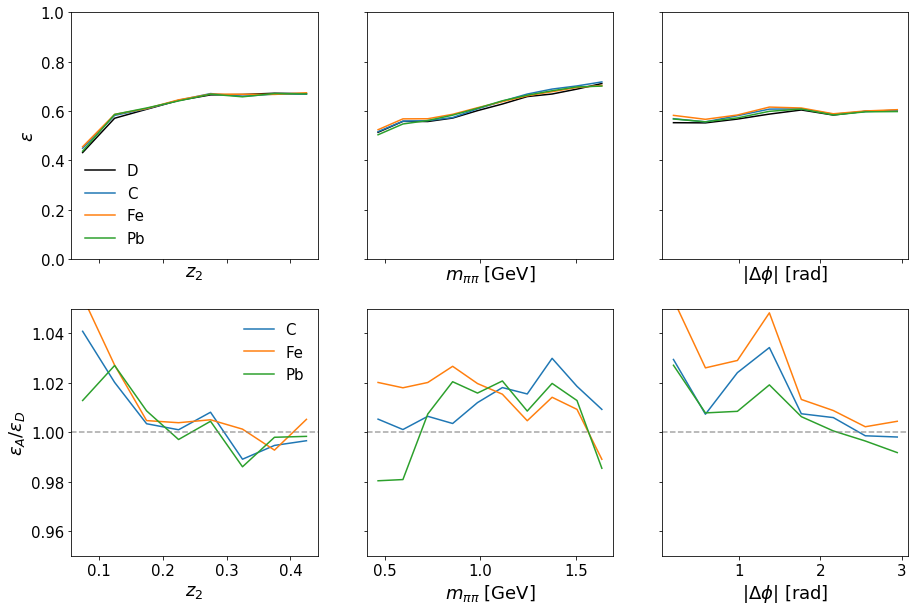

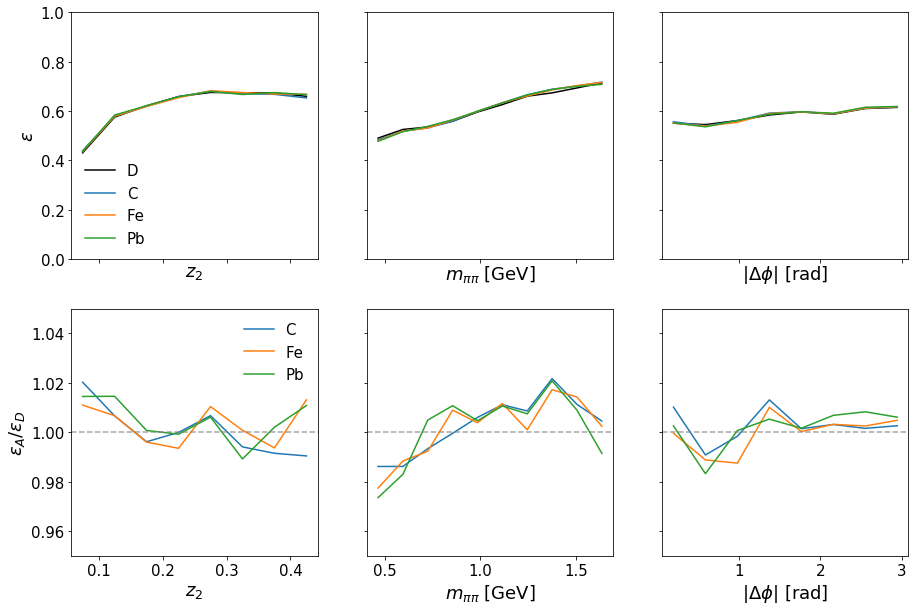

In [24]:
for w in [True, False]:
    fig, axs= plt.subplots(2,3, figsize=(15,10),sharey='row', sharex='col')
    sumsq = 0
    for i,(bins, xvar_truth) in enumerate([(np.linspace(0.05,.45,9),'h2_truth_z'),
                            (np.linspace(0.4,1.7,11),'pair_mass_truth'),
                            (np.linspace(0,np.pi,9),'dphi_truth')]):
        for a in "D C Fe Pb".split():

            df = dfs_mc[f'{a}_2pi']#.query("weight_truth>0")
            w_default = np.mean(df.query("pass_recon==1").weight_truth)
            if w:
                weight=f"weight_truth*pass_reco+(pass_reco!=0)*{w_default}"
                weight=f"weight_truth"
            else :
                weight = "Q2/Q2"
            n_pass,x = np.histogram(df.query("pass_recon==1")[xvar_truth],
                                    weights=df.query("pass_recon==1").eval(weight),
                                    bins=bins)
            n_tot,x = np.histogram(df[xvar_truth], 
                                    weights=df.eval(weight),
                                    bins=bins)
            bin_centers = 0.5*(x[1:]+x[:-1])

            plt.sca(axs[0][i]) 
            plt.plot(bin_centers, (n_pass/n_tot), color='k' if a == 'D' else None,label=a)
            if(a=='D'):
                n_pass_D = n_pass
                n_tot_D = n_tot

            else :
                plt.sca(axs[1][i]) 
                y = (n_pass/n_tot)/(n_pass_D/n_tot_D)
                sumsq +=sum((y-1)**2)
                plt.plot(bin_centers, y,label=a)
        axs[1][i].axhline(1, color='0.5', alpha=0.7, linestyle='--')
    axs[0][0].legend()
    axs[0][0].set_ylabel("$\epsilon$")
    axs[1][0].legend()
    axs[1][0].set_ylabel("$\epsilon_A/\epsilon_D$")
    
    axs[0][0].set_xlabel("$z_2$")
    axs[0][1].set_xlabel("$m_{\pi\pi}$ [GeV]")
    axs[0][2].set_xlabel("$|\Delta\phi|$ [rad]")
    axs[1][0].set_xlabel("$z_2$")
    axs[1][1].set_xlabel("$m_{\pi\pi}$ [GeV]")
    axs[1][2].set_xlabel("$|\Delta\phi|$ [rad]")
    axs[0][0].set_ylim(0,1)
    axs[1][0].set_ylim(0.95,1.05)
    print(np.sqrt(sumsq/26))
    if w :
        plt.savefig("images/efficiency_weighted.png")
    else :
        plt.savefig("images/efficiency_unweighted.png")
    

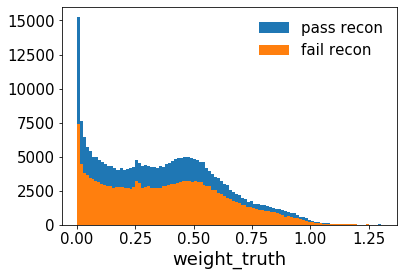

In [28]:
plt.hist(dfs_mc['D_2pi'].query("pass_recon==1").weight_truth,bins=100, label="pass recon")
plt.hist(dfs_mc['D_2pi'].query("pass_recon!=1").weight_truth,bins=100, label="fail recon")
plt.gca().set_xlabel("weight_truth")
plt.gca().legend()
plt.show()

In [29]:
weights_tr = {}
models_tr = {}
histories_tr = {}

variables = 'h1_z x Q2 h1_cm_pt h1_cm_ph'.split()

#for variable in variables:
#    print(dfs_data['D_2pi'].dtypes[variable])
for a in 'D'.split():
    for topo in '_trigger_cut'.split():
        name = a+topo
        
        weights_tr[name], models_tr[name], histories_tr[name] = run_omnifold(dfs_data[name],dfs_mc[name], variables, variables, iterations=4)



2372621
[[ 0.94381837  0.28755605  1.97953987  0.56538982 -1.89546797]
 [ 0.63912242  0.27932572  1.41144776  0.52487476 -3.1121215 ]
 [ 0.92059537  0.28020447  1.87247896  0.79613697 -2.09910072]
 ...
 [ 0.53413653  0.2408874   1.65136147  0.9976151   2.99688219]
 [ 0.78012674  0.40160152  2.92877388  1.10354708 -3.05013024]
 [ 0.65517741  0.24672063  1.62245333  0.43330213 -3.13955848]]
5
2372621
ITERATION: 1
STEP 1...
Epoch 1/1000
475/475 [==============================] - 1s 2ms/step - loss: 0.5267 - accuracy: 0.3753 - val_loss: 0.5111 - val_accuracy: 0.3746
Epoch 2/1000
475/475 [==============================] - 1s 2ms/step - loss: 0.5113 - accuracy: 0.3752 - val_loss: 0.5101 - val_accuracy: 0.3754
Epoch 3/1000
475/475 [==============================] - 1s 2ms/step - loss: 0.5095 - accuracy: 0.3753 - val_loss: 0.5088 - val_accuracy: 0.3746
Epoch 4/1000
475/475 [==============================] - 1s 2ms/step - loss: 0.5085 - accuracy: 0.3753 - val_loss: 0.5085 - val_accuracy: 0.3750

712/712 [==============================] - 1s 2ms/step - loss: 0.3497 - accuracy: 0.2508 - val_loss: 0.3495 - val_accuracy: 0.2511
Epoch 7/1000
712/712 [==============================] - 1s 2ms/step - loss: 0.3497 - accuracy: 0.2509 - val_loss: 0.3500 - val_accuracy: 0.2517
Epoch 8/1000
712/712 [==============================] - 1s 2ms/step - loss: 0.3497 - accuracy: 0.2509 - val_loss: 0.3498 - val_accuracy: 0.2517
Epoch 9/1000
712/712 [==============================] - 1s 2ms/step - loss: 0.3497 - accuracy: 0.2509 - val_loss: 0.3509 - val_accuracy: 0.2507
Epoch 10/1000
712/712 [==============================] - 1s 2ms/step - loss: 0.3497 - accuracy: 0.2508 - val_loss: 0.3501 - val_accuracy: 0.2505
Epoch 11/1000
712/712 [==============================] - 1s 2ms/step - loss: 0.3496 - accuracy: 0.2509 - val_loss: 0.3505 - val_accuracy: 0.2512
Epoch 12/1000
712/712 [==============================] - 1s 2ms/step - loss: 0.3496 - accuracy: 0.2509 - val_loss: 0.3507 - val_accuracy: 0.2500
Ep

Epoch 46/1000
475/475 [==============================] - 1s 2ms/step - loss: 0.3614 - accuracy: 0.3754 - val_loss: 0.3614 - val_accuracy: 0.3814
Epoch 47/1000
475/475 [==============================] - 1s 2ms/step - loss: 0.3614 - accuracy: 0.3759 - val_loss: 0.3614 - val_accuracy: 0.3810
Epoch 48/1000
475/475 [==============================] - 1s 2ms/step - loss: 0.3614 - accuracy: 0.3757 - val_loss: 0.3615 - val_accuracy: 0.3806
Epoch 49/1000
475/475 [==============================] - 1s 2ms/step - loss: 0.3613 - accuracy: 0.3762 - val_loss: 0.3614 - val_accuracy: 0.3780
Epoch 50/1000
475/475 [==============================] - 1s 2ms/step - loss: 0.3614 - accuracy: 0.3762 - val_loss: 0.3612 - val_accuracy: 0.3762
Epoch 51/1000
475/475 [==============================] - 1s 2ms/step - loss: 0.3613 - accuracy: 0.3763 - val_loss: 0.3612 - val_accuracy: 0.3777
Epoch 52/1000
475/475 [==============================] - 1s 2ms/step - loss: 0.3613 - accuracy: 0.3754 - val_loss: 0.3614 - val_ac

475/475 [==============================] - 1s 2ms/step - loss: 0.3495 - accuracy: 0.3543 - val_loss: 0.3498 - val_accuracy: 0.3527
Epoch 5/1000
475/475 [==============================] - 1s 2ms/step - loss: 0.3497 - accuracy: 0.3544 - val_loss: 0.3500 - val_accuracy: 0.3513
Epoch 6/1000
475/475 [==============================] - 1s 2ms/step - loss: 0.3494 - accuracy: 0.3543 - val_loss: 0.3497 - val_accuracy: 0.3574
Epoch 7/1000
475/475 [==============================] - 1s 2ms/step - loss: 0.3493 - accuracy: 0.3530 - val_loss: 0.3495 - val_accuracy: 0.3566
Epoch 8/1000
475/475 [==============================] - 1s 2ms/step - loss: 0.3493 - accuracy: 0.3546 - val_loss: 0.3495 - val_accuracy: 0.3507
Epoch 9/1000
475/475 [==============================] - 1s 2ms/step - loss: 0.3493 - accuracy: 0.3542 - val_loss: 0.3495 - val_accuracy: 0.3699
Epoch 10/1000
475/475 [==============================] - 1s 2ms/step - loss: 0.3492 - accuracy: 0.3555 - val_loss: 0.3496 - val_accuracy: 0.3693
Epoc

In [30]:
for key in weights_tr.keys():
    dfs_mc[key]['weight_reco'] = weights_tr[key][-1, 0, :]
    dfs_mc[key]['weight_truth'] = weights_tr[key][-1, 1, :]
    
print(weights_tr['D_trigger_cut'][-1,1,:])

[0.07239943 0.47701707 0.01985031 ... 0.18126366 0.01065607 0.52604508]


In [31]:
print(dfs_mc['C_2pi'].columns)
    

Index(['dphi', 'dphi_lab', 'drap', 'h1_z', 'h2_z', 'h1_cm_pt', 'h2_cm_pt',
       'h1_xf', 'h2_xf', 'h1_rap',
       ...
       'h2_e', 'h2_mass', 'h1_p', 'h2_p', 'diff_rap_cm', 'h1_mass_TOF',
       'pass_reco', 'pass_truth', 'weight_reco', 'weight_truth'],
      dtype='object', length=116)


In [32]:
#list all data in history
# summarize history for accuracy

def make_history_plots(key):
    history = histories[key]
    for i in range(4):
        fig,ax = plt.subplots(1,2,figsize=(16,6))
        ax[0].set_title('Step 1: \nreweight sim. from data')
        ax[0].set_xlabel('epoch number')
        ax[0].plot(history['step1'][i].history['loss'][1:],'o',label='Step 1 train loss')
        ax[0].plot(history['step1'][i].history['val_loss'][1:],'o',label='Step 1 test loss')
        ax[0].legend()

        #ax[1].set_title('model accuracy')
        #ax[1].plot(history['step1'][i].history['accuracy'][1:],'o',label='Step 1 train')
        #ax[1].plot(history['step1'][i].history['val_accuracy'][1:],'o',label='Step 1 test')
        #ax[1].legend()
        #ax[1].set_xlabel('epoch number')

        ax[1].set_title('Step 2: \nreweight gen. from sim.')
        ax[1].set_xlabel('epoch number')
        ax[1].plot(history['step2'][i].history['loss'][1:],'o',label='Step 2 train loss')
        ax[1].plot(history['step2'][i].history['val_loss'][1:],'o',label='Step 2 test loss')
        ax[1].legend()

        #ax[3].set_title('model accuracy')
        #ax[3].plot(history['step2'][i].history['accuracy'][1:],'o',label='Step 2 train')
        #ax[3].plot(history['step2'][i].history['val_accuracy'][1:],'o',label='Step 2 test')
        #ax[3].legend()
        #ax[3].set_xlabel('epoch number')

        #for a in ax:
        #    a.set_ylim(0)
        plt.savefig(f"images/reweight_history_iter_{i}_{key}.png",bbox_inches='tight')

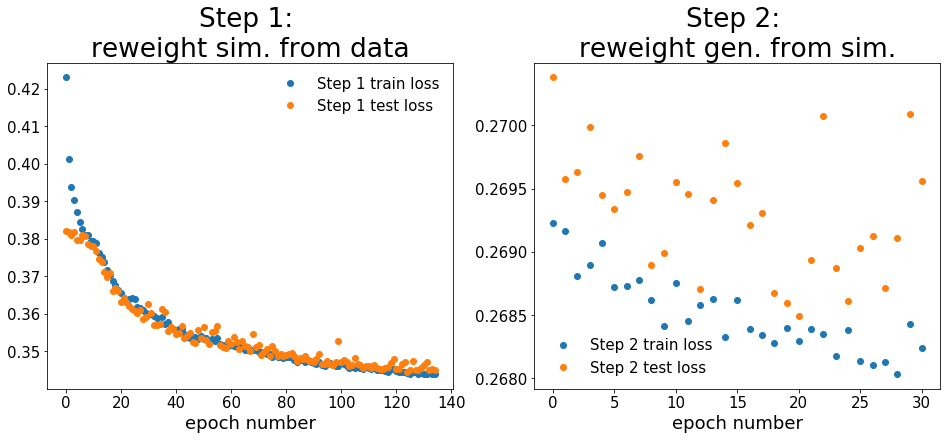

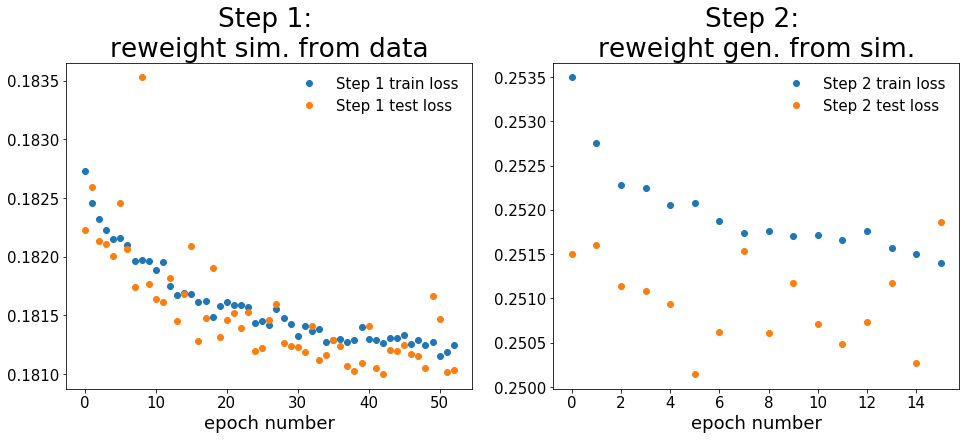

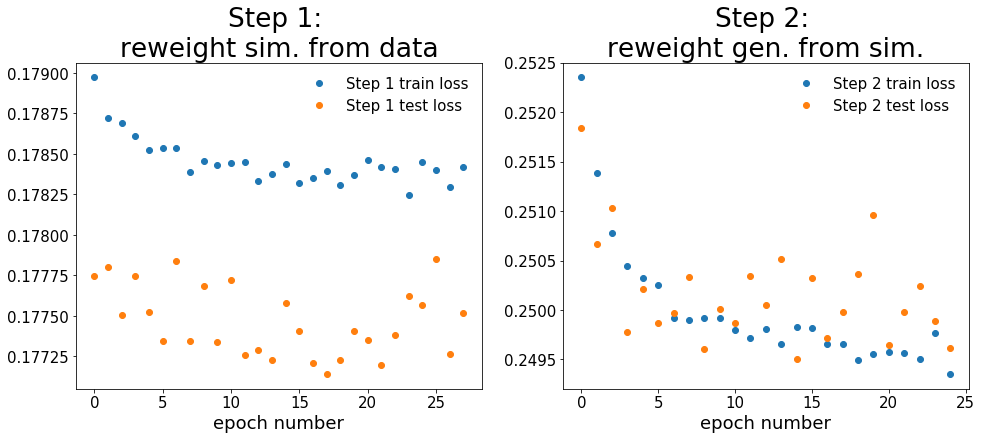

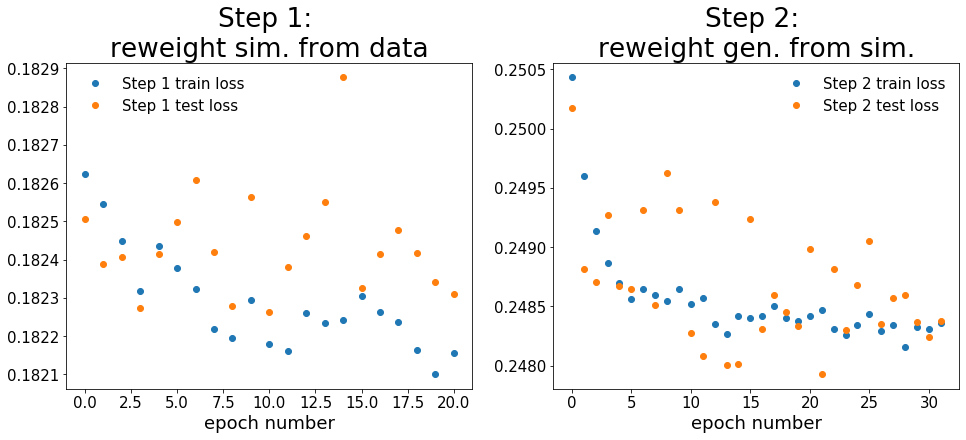

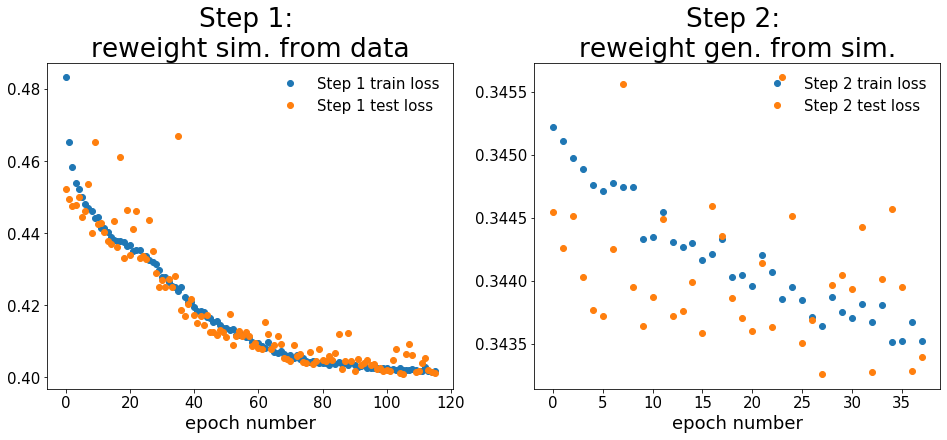

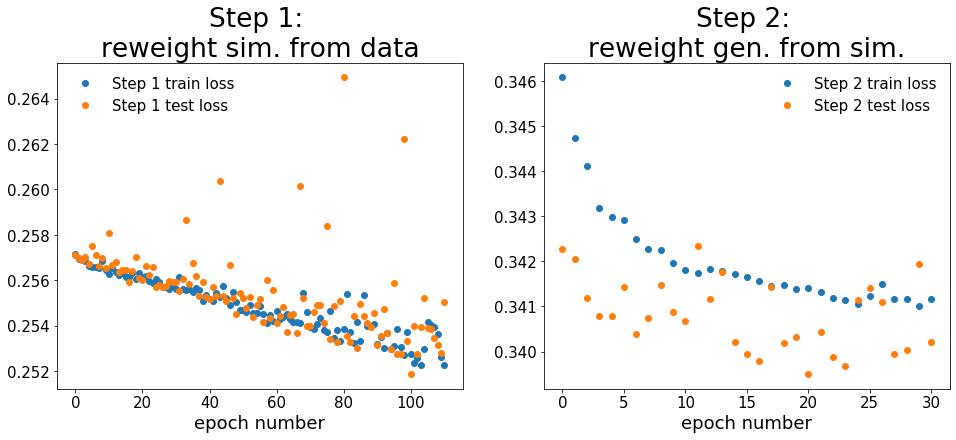

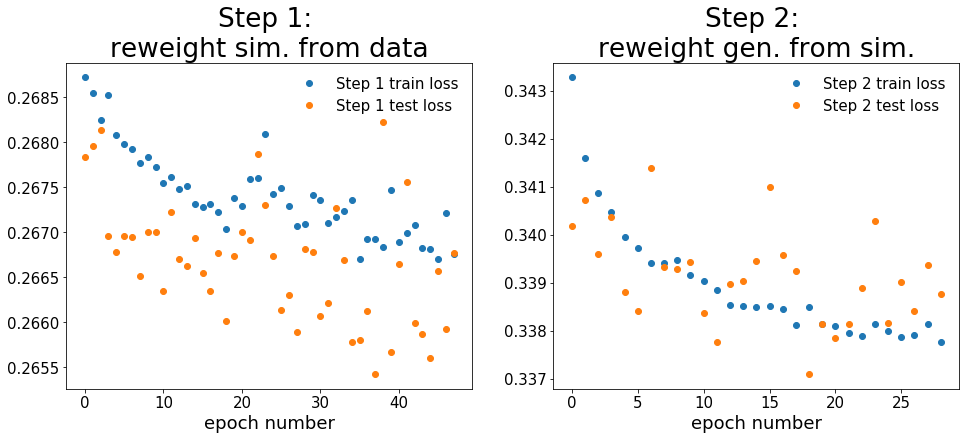

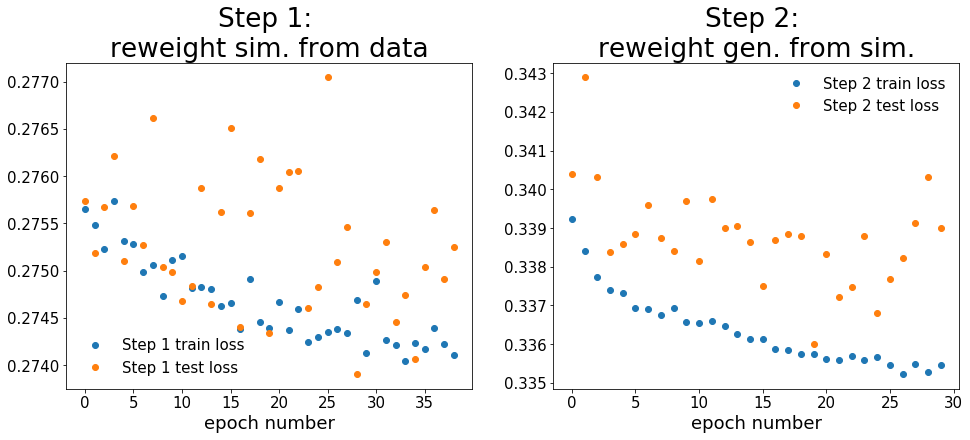

In [33]:
make_history_plots('C_2pi')
make_history_plots('D_2pi')

## Plot data and MC reweighted

In [34]:
## This is what in Ben's notebook. 
## The _S is RECO level. 
## You require that the RECO dataframe has a valid pass reco.
## The G is the truth level
## You required that the truth level has pass_truth valid.

In [35]:
#


def reweight_summary_plots(setname, showIter=False):
    df_data = dfs_data[setname].query("h1_pid*h2_pid<0")
    df_mc = dfs_mc[setname].query("h1_pid*h2_pid<0")
    for i in (len(weights[setname])-1,):
        pass_reco = df_mc.pass_reco != 0
        print(len(pass_reco))
        print("ITERATION: {}".format(i + 1))
        for df in df_data, df_mc:
            if not 'diff_phi_lab' in df.columns:
                df.eval('diff_phi_lab = (h1_ph-h2_ph)',inplace=True)
                df['diff_phi_lab'] = df.diff_phi_lab+(df.diff_phi_lab>180)*-360+(df.diff_phi_lab<-180)*360
        fig, ax = plt.subplots(3,
                               3,
                               figsize=(16, 16),
                               constrained_layout=True)
        #fig.suptitle(suptitles[setname])

        bins = [[np.linspace(0.0, 4.2, 40), np.linspace(0, 0.6, 50), np.linspace(-np.pi, np.pi, 50)],
               [np.linspace(0, 1, 50), np.linspace(0, 1.5, 50), np.linspace(-np.pi, np.pi, 50)],
               [np.linspace(0, 1, 50), np.linspace(0, 1.5, 50), np.linspace(0.3, 1.7, 50)]]
        xlabels = [[r'$Q^{2}$ [GeV$^2$]', r'$x$', r'$\Delta\phi_{\mathrm{lab}}$ [rad]'],
                  [r'$z_1$', r'$p^1_T$ [GeV]', r'$\Delta\phi$ [rad]'],
                  [r'$z_2$', r'$p^2_T$ [GeV]', r'$m_{\pi\pi}$ [GeV]']]
        xvars = [['Q2', 'x', f'diff_phi_lab*{np.pi}/180'],
                ['h1_z', 'h1_cm_pt','diff_phi_cm'],
                ['h2_z', 'h2_cm_pt','pair_mass']]

        for row in range(3):
            for col in range(3):

                ax[row,col].set_xlabel(xlabels[row][col])
                ax[row,col].set_ylabel('Events per bin (Normalized)')
                #ax[row,col].hist(df_mc[xvars[row][col]][pass_reco], bins=bins[row][col], label=r'MC .', **plot_style_2)
                #print(len(weights), len(weights[i,0,:]), len(pass_reco),len(df_data))

                ax[row,col].hist(df_mc[pass_reco].eval(xvars[row][col]),
                           bins=bins[row][col],
                           weights=weights[setname][i, 0, :][pass_reco],
                           label=r'MC',
                           **plot_style_2)

                #ax[row,col].hist(df_data[xvars[row][col]],
                #           bins=bins[row][col],
                #           label=r'Data (reco)',
                #           **plot_style_2)
                y,x = np.histogram(df_data.eval(xvars[row][col]),
                           bins=bins[row][col])
                
                denom = np.sum(y)*(x[1]-x[0])
                #print(y/denom)
                x = 0.5*(x[1:]+x[:-1])#bin centers
                ax[row,col].errorbar(x,y/denom,np.sqrt(y)/denom, color='k', label='Data (recon)')
                
                if row == 0 and col == 0:
                    ax[row,col].legend(frameon=False,loc='best')


        fig.savefig(f"images/reweight_summary_{setname}_iter{i}.png",bbox_inches='tight')

366132
ITERATION: 4


<ipython-input-35-63d37ed69cad>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['diff_phi_lab'] = df.diff_phi_lab+(df.diff_phi_lab>180)*-360+(df.diff_phi_lab<-180)*360


IndexError: boolean index did not match indexed array along dimension 0; dimension is 432561 but corresponding boolean dimension is 366132

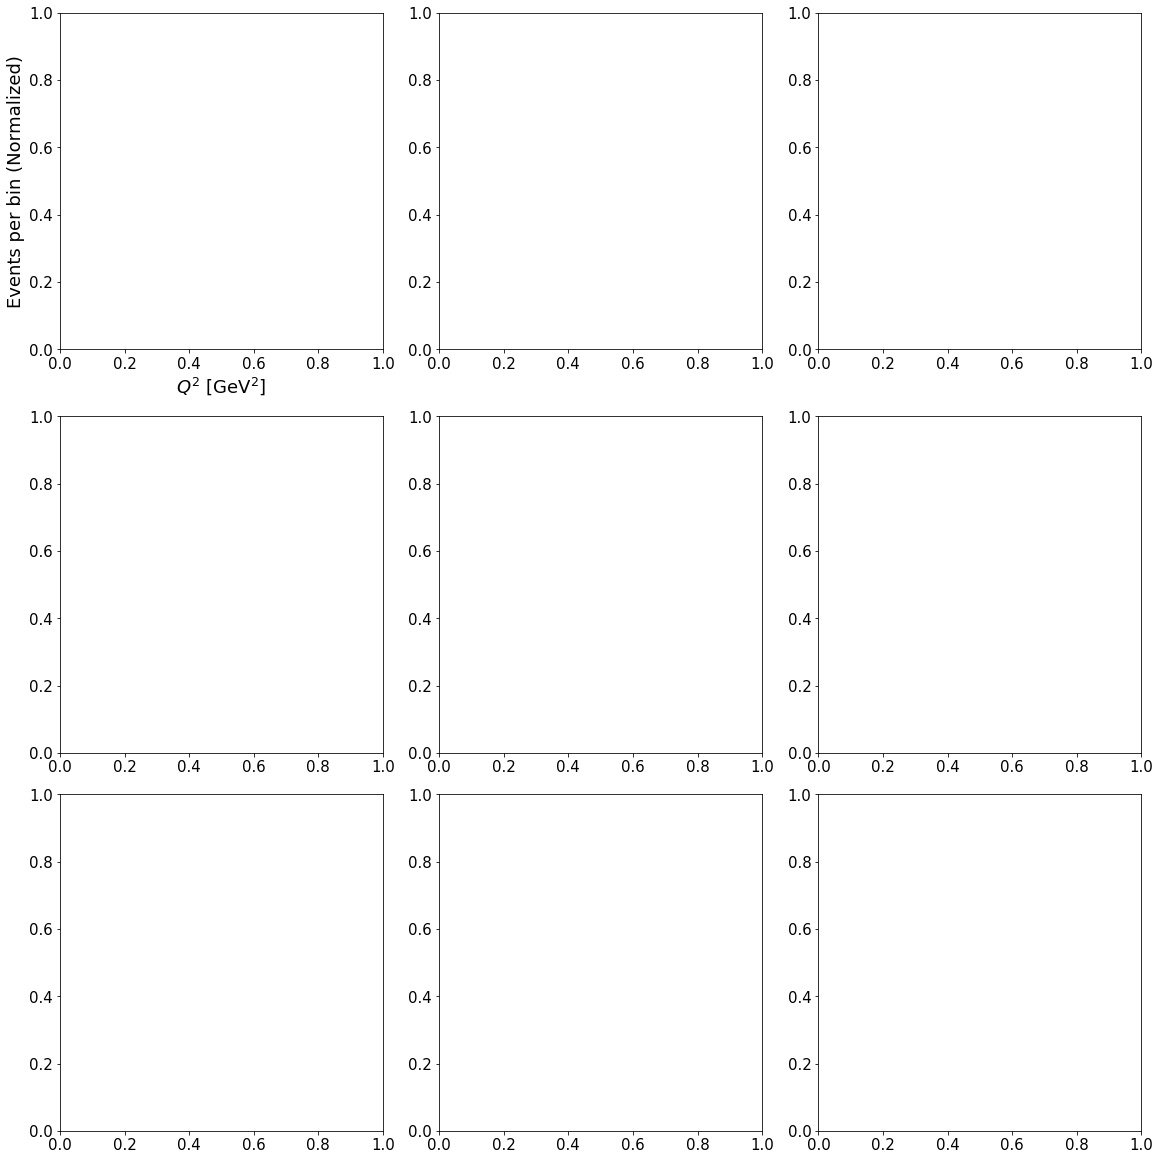

In [36]:
reweight_summary_plots('C_2pi')
#reweight_summary_plots('C_pi_p')
reweight_summary_plots('D_2pi')

## Put weights obtained with the DNN back into the mc dataframe:

In [ ]:
help(root_pandas)

In [37]:
for a in "D C Fe Pb".split():
    df = dfs_mc[f'{a}_2pi']#.query("weight_truth>0")
    w_default = np.mean(df.query("pass_recon==1").weight_truth)
    df['weight_truth']=df.eval(f"weight_truth*pass_reco+(pass_reco!=0)*{w_default}")
for a in "C Fe Pb".split():
    
    d = {f'D_{a}' : dfs_mc['D_2pi'], a: dfs_mc[a+"_2pi"],
        f'D_{a}_trigger' : dfs_mc['D_trigger_cut'], a+"_trigger": dfs_mc[a+"_trigger_cut"],}
    root_pandas.to_root_multi(f"/home/sebouh/CreatePairTuples/MC_Pairs_weighted_{a}.root",d)

In [29]:
#for key in weights.keys():
#    dfs_mc[key]['weight_reco'] = weights[key][-1, 0, :]
#    dfs_mc[key]['weight_truth'] = weights[key][-1, 1, :]
#    dfs_mc[key].to_root(f"/home/sebouh/CreatePairTuples/MC_Pairs_weighted_{key}.root","dihadrons")

# slice plots

In [30]:
def slice_plot(key, xvar,xlabel, bins, slicevar, slicelabel, partitions,
               suptitle=None, sliceUnit=None, legend=False):
    df_mc =dfs_mc[key].query("h1_pid*h2_pid<0")
    df_data =dfs_data[key].query("h1_pid*h2_pid<0")
    fig, axs = plt.subplots(1, len(partitions)-1, 
                            figsize=(4*(len(partitions)-1), 4),sharex='all')
    fig.subplots_adjust(wspace=0)
    if suptitle is not None:
        fig.suptitle(suptitle, y=1.15)
    
    axs[0].set_ylabel('Events per bin (Normalized)')
    for i in range(len(partitions)-1):
        query = f'{slicevar}>{partitions[i]} and {slicevar}<{partitions[i+1]}'
        axs[i].set_xlabel(xlabel)
        title = f'{partitions[i]} <{slicelabel}<{partitions[i+1]}'
        if sliceUnit !=None:
            title += f'[{sliceUnit}]'
        axs[i].set_title(title,fontsize='medium')                 
        mc = df_mc.query(query).query("pass_reco != 0")
        #axs[i].hist(mc.eval(xvar), bins=bins, label=r'MC .', **plot_style_2)
        #print(len(weights), len(weights[i,0,:]), len(pass_reco),len(df_data))

        axs[i].hist(mc.eval(xvar),
                   bins=bins,
                   weights=mc.weight_reco,
                   label=r'MC',
                   **plot_style_2)

        #axs[i].hist(df_data.query(query).eval(xvar),
        #           bins=bins,
        #           label=r'Data (recon)',
        #           **plot_style_2)
        y,x = np.histogram(df_data.query(query).eval(xvar),
                           bins=bins)        
        denom = np.sum(y)*(x[1]-x[0])
        x = 0.5*(x[1:]+x[:-1])#bin centers
        axs[i].errorbar(x,y/denom,np.sqrt(y)/denom, color='k', label='Data (recon)')
        
        if i==0 and legend:
            axs[i].legend(frameon=False,loc='best')
    plt.savefig(f"images/reweight_eg2_slices_{slicevar}_vs_{xvar}_{key}.png",bbox_inches='tight')
        


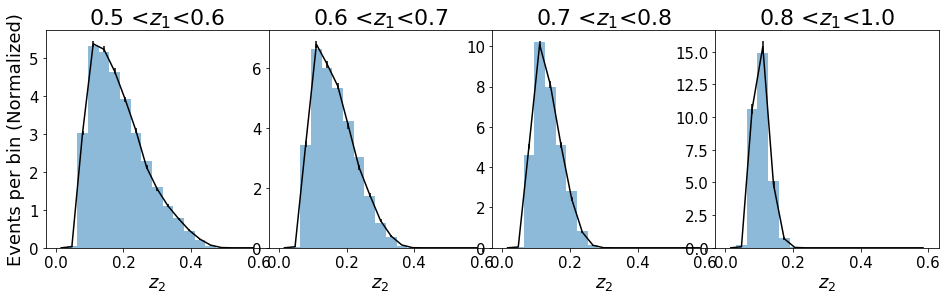

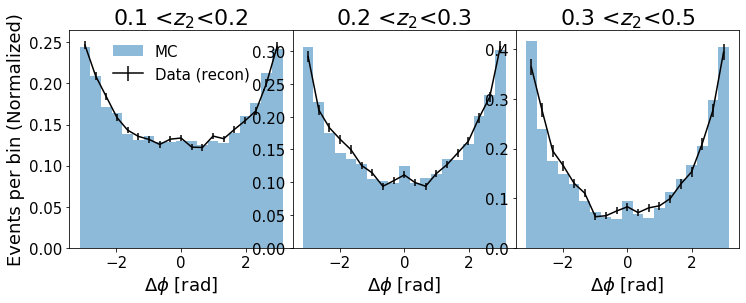

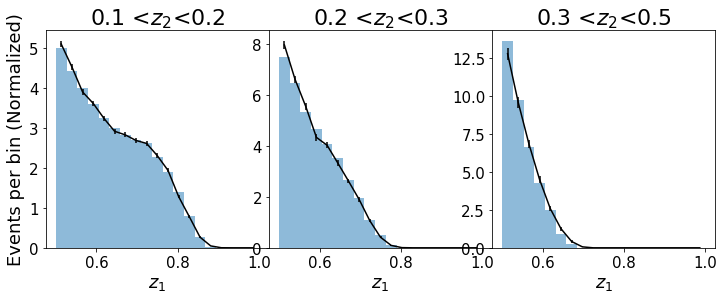

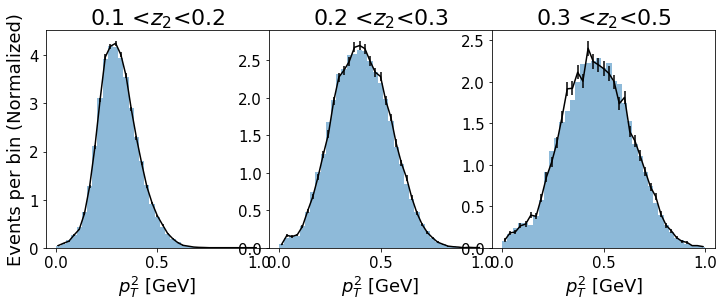

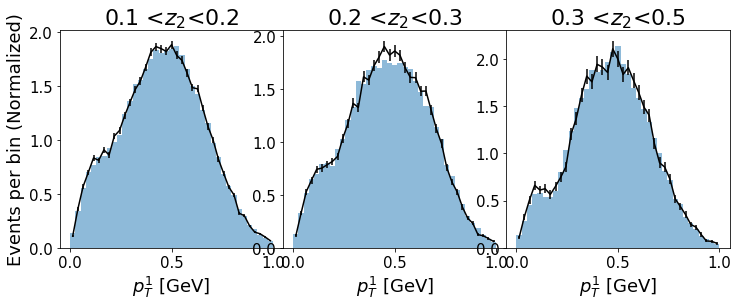

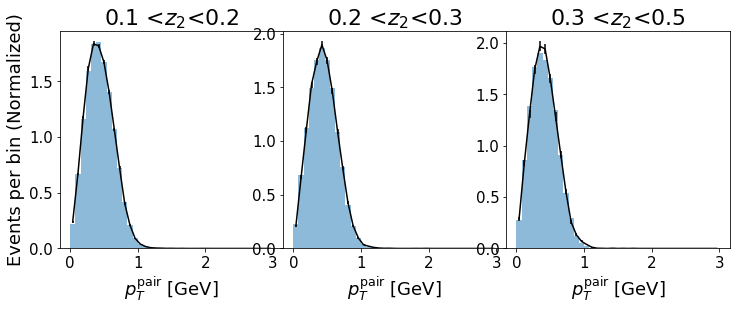

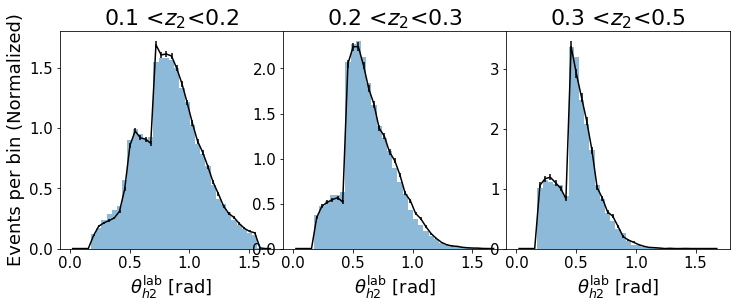

In [31]:

for key in 'D_2pi'.split():
    #determine the suptitle to use
    suptitle = None #suptitles[key]
    
    #z1 slices, z2 bins
    slice_plot(key, 'h2_z', '$z_2$', np.linspace(0,.6 if '2pi' in key else .8, 20), 
               'h1_z', '$z_1$', (0.5, 0.6, 0.7, 0.8,1.0), suptitle=suptitle)
    #slice_plot(key, 'diff_phi_cm', r'$\Delta\phi_{cm}$ [rad]', np.linspace(-np.pi,np.pi, 20), 
    #       'diff_rap_cm', r'$\Delta y_{cm}$', (-0.5, 1.0, 2.0, 3.0), suptitle=suptitle)
    
    #z2 slices, diff_phi_cm
    slice_plot(key, 'diff_phi_cm', r'$\Delta\phi$ [rad]', np.linspace(-np.pi,np.pi, 20), 
           'h2_z', r'$z_2$', (0.1, 0.2, 0.3, 0.5), suptitle=suptitle,legend=True)
    #slice_plot(key, 'x', r'$x$', np.linspace(0.1, 0.6, 40), 
    #       'Q2', r'$Q^2$', (1.0, 2.0, 3.0, 4.0), suptitle=suptitle,sliceUnit='GeV$^2$')
    #slice_plot(key, 'h1_cm_pt', r'$p^1_T$', np.linspace(0, 1, 40), 
    #       'h2_cm_pt', r'$p^2_T$', (0, 0.3, 0.6, 0.9), suptitle=suptitle,sliceUnit='GeV')
    slice_plot(key, 'h1_z', '$z_1$', np.linspace(0.5,1, 20), 
               'h2_z', '$z_2$', (0.1, 0.2, 0.3, 0.5), suptitle=suptitle)
    
    slice_plot(key, 'h2_cm_pt', r'$p^2_T$ [GeV]', np.linspace(0, 1, 40), 
           'h2_z', r'$z_2$', (0.1, 0.2, 0.3, 0.5), suptitle=suptitle,sliceUnit=None)
    slice_plot(key, 'h1_cm_pt', r'$p^1_T$ [GeV]', np.linspace(0, 1, 40), 
           'h2_z', r'$z_2$', (0.1, 0.2, 0.3, 0.5), suptitle=suptitle,sliceUnit=None)
    
    slice_plot(key, 'pair_pt', r'$p^{\mathrm{pair}}_T$ [GeV]', np.linspace(0, 3, 40), 
           'h2_z', r'$z_2$', (0.1, 0.2, 0.3, 0.5), suptitle=suptitle,sliceUnit=None)
    
    slice_plot(key, f'h2_th*{np.pi/180}', r'$\theta^{\mathrm{lab}}_{h2}$ [rad]', np.linspace(0, 1.7, 40), 
           'h2_z', r'$z_2$', (0.1, 0.2, 0.3, 0.5), suptitle=suptitle,sliceUnit=None)

In [149]:
print(dfs_mc['C_2pi'].columns)

Index(['dphi', 'dphi_lab', 'drap', 'h1_z', 'h2_z', 'h1_cm_pt', 'h2_cm_pt',
       'h1_xf', 'h2_xf', 'h1_rap',
       ...
       'z_tot', 'h1_mass2_TOF', 'h2_mass2_TOF', 'pair_pt2', 'h1_mass_TOF',
       'pass_reco', 'pass_truth', 'diff_phi_lab', 'weight_reco',
       'weight_truth'],
      dtype='object', length=108)


(array([5255., 5035., 4603., 4231., 4053., 3901., 4102., 4224., 4141.,
        4267., 4244., 4381., 4383., 4765., 4996., 5151., 5253., 5091.,
        4524., 4022., 3523., 3348., 3101., 3014., 2817., 2760., 2601.,
        2577., 2526., 2643., 2724., 2913., 2978., 2861., 2727., 2504.,
        2096., 1912., 1751., 1600., 1619., 1517., 1504., 1479., 1525.,
        1561., 1704., 1859., 2049., 2127., 2205., 2025., 1878., 1736.,
        1572., 1619., 1435., 1619., 1517., 1555., 1663., 1780., 1882.,
        2062., 2406., 2761., 3023., 2953., 2895., 2831., 2584., 2533.,
        2591., 2635., 2766., 2862., 2992., 3199., 3329., 3637., 4019.,
        4563., 5088., 5286., 5272., 4862., 4637., 4486., 4454., 4199.,
        4269., 4245., 4146., 4172., 4045., 4190., 4445., 4734., 4963.,
        5271.]),
 array([-1.79999596e+02, -1.76399605e+02, -1.72799614e+02, -1.69199624e+02,
        -1.65599633e+02, -1.61999643e+02, -1.58399652e+02, -1.54799661e+02,
        -1.51199671e+02, -1.47599680e+02, -1.43999

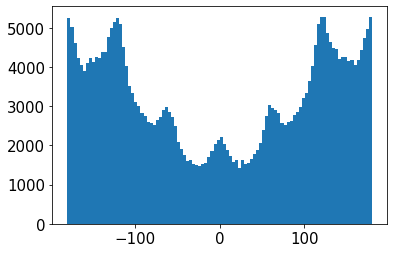

In [150]:
plt.hist(dfs_mc['D_2pi'].eval('h1_ph-h2_ph+360*(h1_ph-h2_ph<-180)-360*(h1_ph-h2_ph>180)'),bins=100)

/home/sebouh/.local/lib/python3.8/site-packages/numpy/lib/histograms.py:905: RuntimeWarning: invalid value encountered in true_divide
  return n/db/n.sum(), bin_edges


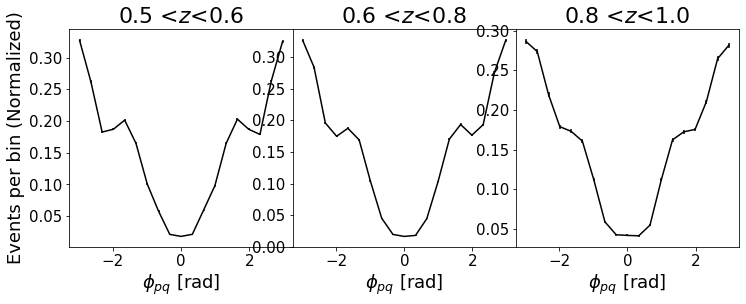

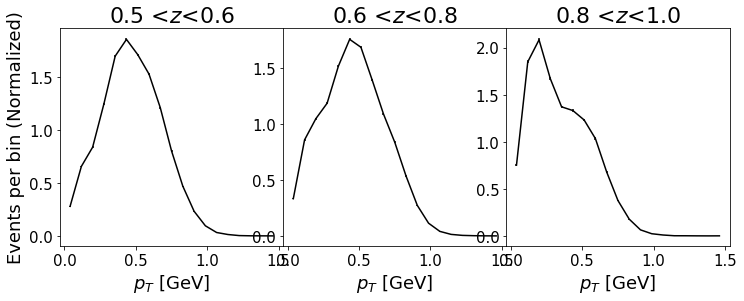

In [37]:
for key in 'D_trigger_cut'.split():
    #determine the suptitle to use
    suptitle = None #suptitles[key]
    
    slice_plot(key, 'h1_cm_ph', '$\\phi_{pq}$ [rad]', np.linspace(-np.pi,np.pi, 20), 
               'h1_z', '$z$', (0.5, 0.6, 0.8,1.0), suptitle=suptitle)
    
    slice_plot(key, 'h1_cm_pt', '$p_T$ [GeV]', np.linspace(0,1.5, 20), 
               'h1_z', '$z$', (0.5, 0.6, 0.8,1.0), suptitle=suptitle)

In [74]:
print(dfs_mc.keys())

dict_keys(['D_2pi', 'D_pi_p', 'D_trigger_cut', 'C_2pi', 'C_pi_p', 'C_trigger_cut'])


In [69]:
d = {}
for a in 'D C Fe Pb'.split():
    q = "dphi< 0.1"
    rd = len(dfs_data[a+"_2pi"].query(q))/len(dfs_data[a+"_trigger_cut"])
    rw = sum(dfs_mc[a+"_2pi"].query(q).weight_reco)/len(dfs_mc[a+"_trigger_cut"])
    d[a] = rd/rw
print({a:d[a]/d['D'] for a in 'C Fe Pb'.split()})

{'C': 1.2854192723717053, 'Fe': 1.0891773832191007, 'Pb': 1.0905072085165464}


In [66]:
print(len(dfs_all[f'MC_{a}_2pi'].query("h2_z>0")))
print(len(dfs_all[f'MC_{a}_2pi']))

62313
62313
